In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mk=3

##0. Initial 

In [3]:
import scipy.io
import numpy as np
file_name = '/content/drive/MyDrive/2022_SUMMER/Research_Burger/CODE/TranslatePythonCode/'
#file_name = '/content/drive/MyDrive/tamu/BurgerResults/'
mat = scipy.io.loadmat(file_name + 'canadafastfood_resorted.mat')
data = mat['data']#[np.where(mtype_int==1)]
TimePeriod = len(np.unique(data[:,1]))
SamplePath = int(len(data)/TimePeriod)
print(TimePeriod,SamplePath)
print(data[:,0].reshape([TimePeriod,SamplePath]).T)

#% Labeling
MT = len(data)          #% Size of the dataset (M x T = 400 x 35 = 14000).#clusterid = np.int_(data[:,0])      % Unique market ID.
year = np.int_(data[:,1]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
pop = data[:,23].reshape([TimePeriod,SamplePath]).T.reshape(-1)
val = data[:,24].reshape([TimePeriod,SamplePath]).T.reshape(-1)
inc = data[:,25].reshape([TimePeriod,SamplePath]).T.reshape(-1)
fpop = data[:,27].reshape([TimePeriod,SamplePath]).T.reshape(-1)
finc = data[:,28].reshape([TimePeriod,SamplePath]).T.reshape(-1)
fval = data[:,29].reshape([TimePeriod,SamplePath]).T.reshape(-1)
mktfe = data[:,30].reshape([TimePeriod,SamplePath]).T.reshape(-1) #% Market fixed effect estimates (from 130913_alaToivanenWaterson3_Fixedeffect3quantile.csv/dta)
tertile = np.int_(data[:,31]).reshape([TimePeriod,SamplePath]).T.reshape(-1)       #% Market type initial guess (from 130913_alaToivanenWaterson3_Fixedeffect3quantile.csv/dta)

35 400
[[  1.   1.   1. ...   1.   1.   1.]
 [  2.   2.   2. ...   2.   2.   2.]
 [  3.   3.   3. ...   3.   3.   3.]
 ...
 [398. 398. 398. ... 398. 398. 398.]
 [399. 399. 399. ... 399. 399. 399.]
 [400. 400. 400. ... 400. 400. 400.]]


In [4]:
def quantile(x,p):
  x = np.sort(x)
  n = len(x)
  x = np.hstack([x[0], x,x[-1]])
  i = p*n+1.5
  iu = int(np.ceil(i))
  il = int(np.floor(i))
  d = i-il
  qq = x[il-1]*(1-d)+x[iu-1]*d
  return qq

#% Number of pop,val,inc (in state space; capped at 3)
pop25 = quantile(pop,0.25)
val25 = quantile(val,0.25)   
inc25 = quantile(inc,0.25)  
pop50 = quantile(pop,0.5) 
val50 = quantile(val,0.5)   
inc50 = quantile(inc,0.5)  
pop75 = quantile(pop,0.75) 
val75 = quantile(val,0.75)   
inc75 = quantile(inc,0.75)   
disc_pop = np.int_(pop > pop25) + np.int_(pop > pop50) + np.int_(pop > pop75)  
disc_val = np.int_(val > val25) + np.int_(val > val50) + np.int_(val > val75)  
disc_inc = np.int_(inc > inc25) + np.int_( inc > inc50) + np.int_(inc > inc75)

In [5]:
numstates = 5 # ni,nj,pop,val,inc
states_full = np.arange(4**numstates)
Ni = states_full//(4**(numstates-1))                       #Number of own outlets: {0,1,2,3+}.
Nj = states_full%(4**(numstates-1))//(4**(numstates-2))    #Number of rival outlets: {0,1,2,3+}.
dz1 = states_full%(4**(numstates-2))//(4**(numstates-3))   #Discretized population state: {0,1,2,3}.
dz2 = states_full%(4**(numstates-3))//(4**(numstates-4))   #Discretized property value state: {0,1,2,3}.
dz3 = states_full%(4**(numstates-4))                       #Discretized income state: {0,1,2,3}.
print(np.sum(np.abs(Ni*4**4+Nj*4**3+dz1*4**2+dz2*4**1+dz3-states_full)))
states = np.stack([Ni,Nj,dz1,dz2,dz3],axis=1)

0


In [6]:
import pandas as pd
filename = '/content/drive/MyDrive/2022_SUMMER/Research_Burger/Picture/'#file_name#
data_extra = pd.read_csv(filename+'ExtraData.csv')
print(data_extra.columns)
obser = 2
# gdp = data_extra['Inflation_Rate']#['disc_inf']#['disc_une']#['Inflation_Rate']#['GDP_Grwoth_Rate']#['Unemployment_Rate']#
gdp = data_extra['GDP_Grwoth_Rate']#['disc_inf']#['disc_une']#['disc_gdp']
gdp50 = quantile(gdp,0.5)
print(gdp50)
disc_gdp = np.int_(gdp>0)#<gdp50)#)#np.int_(gdp <0)#
trans_gdp = np.zeros([obser,obser],dtype=int)

for i in range(34):
  trans_gdp[disc_gdp[i],disc_gdp[i+1]] +=1
print(trans_gdp)
trans_gdp = trans_gdp/np.kron(np.ones([1,obser]),np.sum(trans_gdp,axis=1).reshape([-1,1]))
print(trans_gdp)
disc_gdp = (np.repeat(disc_gdp[0:TimePeriod],SamplePath).reshape([TimePeriod,SamplePath]).T).reshape(-1)

Index(['year', 'GDP_Grwoth_Rate', 'Inflation_Rate', 'Unemployment_Rate', 'GDP',
       'Government Budget', 'Government Debt', 'Medical Doctors',
       'Tip1_GDP_Grwoth_Rate', 'Tip2_GDP_Growth_Yearly',
       'Tip3_GDP_Growth_Annualy', 'Tip4_GDP_Growth_AVGAnnualy', 'Unnamed: 12',
       'Unemployment_Rate_GrowthRate', 'GDP_Growth_Yearly',
       'Medical_Doctors_Growth_Yearly', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'disc_gdp', 'disc_une', 'disc_inf', 'InflationRate_wb',
       'InflationRateLag_wb', 'InflationRateLag2_wb', 'IncInflationRate_wb',
       'IncInflationRateLag_wb', 'IncInflationRateLag2_wb', 'UneRate_wb',
       'UneRateLag_wb', 'UneRateLag2_wb', 'IncUneRate_wb', 'IncUneRateLag_wb',
       'IncUneRateLag2_wb', 'RealGDP_wb', 'GrowthRealGDP_wb', 'disc_InfInc',
       'disc_InfIncLag', 'disc_InfIncLag2', 'disc_UneInc', 'disc_UneIncLag',
       'disc_UneIncLag2', 'disc_RealGdpGrowth'],
      dtype='object')
0.8464467005
[[ 1  2]
 [ 2 29]]
[[0.33333333 0.66666667

#Partial

##1. Global transtion F_Ni, F_dz1,F_dz2,F_dz3

In [7]:
I = 2 #MCD and Other homogenous
J = 3 #Action: 0,1,2
NS = 4**(numstates)
NX = 50
NZ = obser

F_Ni = np.zeros([I,J,NX,NS,NS])#;
#for i in range(NX): 
F_Ni[0,0] = np.kron(np.array([[1]*4**4+[0]*4**4 + [0] *4**4+[0]*4**4]*4**4 +\
                          [[1]*4**4+[0]*4**4 + [0] *4**4+[0]*4**4]*4**4 + \
                          [[0]*4**4+[1]*4**4 + [0] *4**4+[0]*4**4]*4**4 + \
                          [[0]*4**4+[0]*4**4 + [1] *4**4+[0]*4**4]*4**4 ),np.ones([NX,1,1]))
F_Ni[0,1] =np.kron(np.array([[1]*4**4+[0]*4**4 + [0] *4**4+[0]*4**4]*4**4 +\
                          [[0]*4**4+[1]*4**4 + [0] *4**4+[0]*4**4]*4**4 + \
                          [[0]*4**4+[0]*4**4 + [1] *4**4+[0]*4**4]*4**4 + \
                          [[0]*4**4+[0]*4**4 + [0] *4**4+[1]*4**4]*4**4 ),np.ones([NX,1,1]))
F_Ni[0,2] = np.kron(np.array([[0]*4**4+[1]*4**4 + [0] *4**4+[0]*4**4]*4**4 +\
                          [[0]*4**4+[0]*4**4 + [1] *4**4+[0]*4**4]*4**4 + \
                          [[0]*4**4+[0]*4**4 + [0] *4**4+[1]*4**4]*4**4 + \
                          [[0]*4**4+[0]*4**4 + [0] *4**4+[1]*4**4]*4**4 ),np.ones([NX,1,1]))
F_Ni[1] = F_Ni[0]

disc_pop_mx = disc_pop[tertile==mk].reshape([-1,TimePeriod])
disc_pop_bk = disc_pop_mx[:,0:TimePeriod-1].reshape(-1)
disc_pop_fw = disc_pop_mx[:,1:TimePeriod].reshape(-1)
disc_val_mx = disc_val[tertile==mk].reshape([-1,TimePeriod])
disc_val_bk = disc_val_mx[:,0:TimePeriod-1].reshape(-1)
disc_val_fw = disc_val_mx[:,1:TimePeriod].reshape(-1)
disc_inc_mx = disc_inc[tertile==mk].reshape([-1,TimePeriod])
disc_inc_bk = disc_inc_mx[:,0:TimePeriod-1].reshape(-1)
disc_inc_fw = disc_inc_mx[:,1:TimePeriod].reshape(-1)

#% F_dz: Make simple & intuitive (4x4) versions for exposition purposes
fz1_4x4 = np.zeros([4,4])#;
fz2_4x4 = np.zeros([4,4])#;
fz3_4x4 = np.zeros([4,4])#;

for x0 in range(4):
    for x1 in range(4):
        numer1 = np.sum((disc_pop_fw == x1) * (disc_pop_bk == x0))#;
        numer2 = np.sum((disc_val_fw == x1) * (disc_val_bk == x0))#;
        numer3 = np.sum((disc_inc_fw == x1) * (disc_inc_bk == x0))#;
        denom1 = np.sum((disc_pop_bk == x0))#;
        denom2 = np.sum((disc_val_bk == x0))#;
        denom3 = np.sum((disc_inc_bk == x0))#;

        fz1_4x4[x0,x1] = numer1 / denom1#;
        fz2_4x4[x0,x1] = numer2 / denom2#;
        fz3_4x4[x0,x1] = numer3 / denom3#;

for i in range(4):
  print("&{}&{:.4f}&{:.4f}&{:.4f}&{:.4f}\\\\".format(i,fz1_4x4[i][0],fz1_4x4[i][1],fz1_4x4[i][2],fz1_4x4[i][3]))
print('------------------------------')
for i in range(4):
  print("&{}&{:.4f}&{:.4f}&{:.4f}&{:.4f}\\\\".format(i,fz2_4x4[i][0],fz2_4x4[i][1],fz2_4x4[i][2],fz2_4x4[i][3]))
print('------------------------------')
for i in range(4):
  print("&{}&{:.4f}&{:.4f}&{:.4f}&{:.4f}\\\\".format(i,fz3_4x4[i][0],fz3_4x4[i][1],fz3_4x4[i][2],fz3_4x4[i][3]))
print('------------------------------')
print(fz1_4x4)
print(fz2_4x4)
print(fz3_4x4)

F_dz1 = np.kron((fz1_4x4[dz1,:])[:,dz1],np.ones([I,J,NX,1,1]))#; % The transition pattern is common across (i,j,mtype)
F_dz2 = np.kron((fz2_4x4[dz2,:])[:,dz2],np.ones([I,J,NX,1,1]))#; % The transition pattern is common across (i,j,mtype)
F_dz3 = np.kron((fz3_4x4[dz3,:])[:,dz3],np.ones([I,J,NX,1,1]))#; % The transition pattern is common across (i,j,mtype)

&0&0.9700&0.0300&0.0000&0.0000\\
&1&0.0000&0.9651&0.0349&0.0000\\
&2&0.0000&0.0010&0.9643&0.0347\\
&3&0.0000&0.0000&0.0027&0.9973\\
------------------------------
&0&0.9430&0.0570&0.0000&0.0000\\
&1&0.0000&0.9162&0.0838&0.0000\\
&2&0.0000&0.0035&0.9115&0.0850\\
&3&0.0000&0.0000&0.0179&0.9821\\
------------------------------
&0&0.9096&0.0904&0.0000&0.0000\\
&1&0.0168&0.8727&0.1105&0.0000\\
&2&0.0000&0.0305&0.8970&0.0724\\
&3&0.0000&0.0000&0.0110&0.9890\\
------------------------------
[[9.69976905e-01 3.00230947e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.65108165e-01 3.48918353e-02 0.00000000e+00]
 [0.00000000e+00 9.65250965e-04 9.64285714e-01 3.47490347e-02]
 [0.00000000e+00 0.00000000e+00 2.65251989e-03 9.97347480e-01]]
[[0.94298921 0.05701079 0.         0.        ]
 [0.         0.91620626 0.08379374 0.        ]
 [0.         0.00353982 0.91150442 0.08495575]
 [0.         0.         0.01785714 0.98214286]]
[[0.90964313 0.09035687 0.         0.        ]
 [0.01681345 0.8726981

##2. Dynamix and SigmaLambda

In [8]:
import itertools
dim_hstate = 2
dim_observe = obser
def Dynamic(theta23):
  trans_val = theta23[0:2]
  obser_val = theta23[2]

  trans = np.zeros([dim_hstate,dim_hstate]) #s_t^h,s_{t+1}^h
  trans[:,0] = trans_val
  trans[:,1] = 1-trans[:,0]
  obser = np.zeros([dim_hstate,dim_observe])
  obser[:,0] = np.array([obser_val,1-obser_val])
  #obser[:,0] = obser_val
  obser[:,1] = 1-obser[:,0]
  return trans,obser
# print(Dynamic(np.array([0.95, 0.05, 0.125])))#,0.125]+[0.1])))#,0.1,0.1])))  
def RealDynamic(theta23_real):
  trans_val = theta23_real
  trans = np.zeros([dim_hstate,dim_hstate])
  trans[:,0] = trans_val
  trans[:,1] = 1-trans[:,0]
  return trans
def SigmaLambda(theta23,z_old = None,x_old=None,T=None,num_discrete = NX):
  trans,obser = Dynamic(theta23)
  if T==None: #generate function for Q function
    x_old =  np.linspace(0,1,num=num_discrete)
    x_new = np.zeros([num_discrete,dim_observe]) #x_old,z_old,z_new
    sigma = np.zeros([num_discrete,dim_observe])

    for z in range(dim_observe):
      #for z_prime in range(dim_observe):
        x_temp = (x_old*trans[0,0] + (1-x_old) * trans[1,0])*obser[0,z]#,z_prime]
        sigma[:,z] = x_temp + (x_old*trans[0,1] + (1-x_old) * trans[1,1])*obser[1,z]#,z_prime]
        sigma_nonzero = np.where(sigma[:,z]!=0)
        x_new[:,z][sigma_nonzero] = x_temp[sigma_nonzero]/sigma[:,z][sigma_nonzero]
  elif T==1:
    x_temp = (x_old*trans[0,0]+(1-x_old)*trans[1,0])*obser[0,z_old]
    sigma = x_temp + (x_old*trans[0,1]+(1-x_old)*trans[1,1])*obser[1,z_old]
    #sigma_nonzero = np.where(sigma!=0)
    x_new = x_temp/sigma#[sigma_nonzero]/sigma[sigma_nonzero]
  else: #generate whole blief in recover process
    x_new = np.zeros([T,len(x_old)])
    sigma = np.zeros([T-1,len(x_old)])
    x_new[0] = x_old
    for t in range(T-1):
      #z = z_old[t,:]
      z_prime = z_old[t+1,:]
      x_temp = (x_new[t]*trans[0,0]+(1-x_new[t])*trans[1,0])*obser[0,z_prime]
      sigma[t] = x_temp + (x_new[t]*trans[0,1]+(1-x_new[t])*trans[1,1])*obser[1,z_prime]
      sigma_nonzero = np.where(sigma[t]!=0)
      x_new[t+1][sigma_nonzero] = x_temp[sigma_nonzero]/sigma[t][sigma_nonzero]

  belief_f = np.floor(x_new*(num_discrete-1))/(num_discrete-1)
  belief_c = np.ceil(x_new*(num_discrete-1))/(num_discrete-1)
  iterpolate = np.zeros(belief_f.shape)
  iterpolate[np.where((belief_f-belief_c)!=0)] = (x_new-belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]      

  return sigma,x_new,[iterpolate,np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))]

# theta23 = np.array([0.95, 0.05,0.125])#,0.125]+[0.1])#,0.1,0.1])
# sigma,_,(iterp,iterf,iterc) = SigmaLambda(theta23)

## 3. Generate P(nj|policy)

In [9]:
F_fix = F_Ni * F_dz1 * F_dz2 *F_dz3
# % Calculate F from P (& global transition matrices F_Ni, F_dz1, F_dz2) 
import time
def updateF(P):
  #% For a given combination of (Ni, dz1, dz2, mtype), make the state indexes (x, x0, x1, x2, x3)
  #% Beliefs: mapping from today's state (Ni,Nj,dz1,dz2) to tomorrow's Nj = {0,1,2,3}
  fnj_mcd = np.zeros([NX,NS,4])#;      % McDonald's belief
  fnj_other = np.zeros([NX,NS,4])#;    % Other 4 chains beliefs

  nj = 0#;         % If today's # of rivals = 0
  x =  (4**4)*Ni + (4**3)*nj + (4**2)*dz1 + 4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 + 4*dz2+dz3#;  % index of today's state for rivals with 0 shops

  fnj_mcd[:,x,0] = P[1,1][:,x0]**4#;                               % Prob(Nj'= 0) from McD's perspective
  fnj_mcd[:,x,1] = 4 * P[1,2][:,x0] * (P[1,1][:,x0]**3)#;       % Prob(Nj'= 1) from McD's perspective
  fnj_mcd[:,x,2] = 6 * (P[1,2][:,x0]**2) * (P[1,1][:,x0]**2)#;   % Prob(Nj'= 2) from McD's perspective
  fnj_mcd[:,x,3] = 4 * (P[1,2][:,x0]**3) * P[1,1][:,x0]#;       % Prob(Nj'= 3) from McD's perspective
  
  fnj_other[:,x,0] = P[0,1][:,x0] * (P[1,1][:,x0]**3)#;         % Prob(Nj'= 0) etc. from Others' perspectives
  fnj_other[:,x,1] = P[0,2][:,x0] * (P[1,1][:,x0]**3) + P[0,1][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;  
  fnj_other[:,x,2] = P[0,2][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[0,1][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  fnj_other[:,x,3] = P[0,2][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0] + P[0,1][:,x0] * (P[1,2][:,x0]**3)
  
  nj = 1#;         % If today's # of rivals = 1                               
  x =  (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  
  fnj_mcd[:,x,0] = P[1,0][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,1] = P[1,1][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,2] = P[1,2][:,x1] * (P[1,1][:,x0]**3) + P[1,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;
  fnj_mcd[:,x,3] = P[1,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  
  fnj_other[:,x,0] = .5 * (P[0,0][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,1][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,2][:,x1] * (P[1,1][:,x0]**3) + P[0,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2))+\
                              .5 * (P[0,2][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2) +\
                        P[0,1][:,x0] * (P[1,2][:,x1] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)\
                        + P[0,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0])\
                        + .5 * (P[0,2][:,x0] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
                      + P[0,2][:,x0] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,2][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,1][:,x1] * (P[1,2][:,x0]**2))

  nj = 2#;         % If today's # of rivals = 2
  x = (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 = (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4**4)*2 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  
  fnj_mcd[:,x,0] = (P[1,0][:,x1]**2) * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,1] = (1/3) * (P[1,0][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * (P[1,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,2] = (1/3) * (P[1,1][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * ((P[1,1][:,x1]**2) * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (1/3) * (P[1,2][:,x2] * (P[1,1][:,x0]**3)  + (P[1,1][:,x2] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)))
  
  fnj_other[:,x,0] = .5 * 0 + .5 * (P[0,0][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,0][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,1][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,1][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x2] * (P[1,1][:,x0]**3)\
      + P[0,1][:,x2] * 3 * P[1,2][:,x0] * P[1,1][:,x0])\
      + .5 * (P[0,2][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0])
  
  nj = 3#;         % If today's # of rivals = 3
  x = (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 = (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4**4)*2 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  x3 = (4**4)*3 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 3 shops
  
  fnj_mcd[:,x,0] = (2/3) * (P[1,0][:,x1]**3) * P[1,1][:,x0]
  fnj_mcd[:,x,1] = (2/3) * (P[1,0][:,x1]**2) * P[1,1][:,x1] + (1/3) * P[1,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,2] = (2/3) * P[1,0][:,x1] * (P[1,1][:,x1]**2) + (1/3) * (P[1,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[1,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (2/3) * (P[1,1][:,x1]**3) * P[1,1][:,x0] + (1/3) * P[1,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)
  
  fnj_other[:,x,0] = .25 * (P[0,0][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])
  fnj_other[:,x,1] = .25 * 0 + .25 * (P[0,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0]\
      + P[0,1][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .25 * (P[0,0][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0]\
      + P[0,1][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .25 * (P[0,1][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,1][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,1][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2))

  F_Nj = np.ones([I,J,NX,NS,NS])
  Denom_mcd = np.matmul(fnj_mcd,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_mcd,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;         % Sum of each row
  fnj_mcd = fnj_mcd / Denom_mcd#;                 % Make sure each row sums up to 1
  fnj_mcd[np.isnan(fnj_mcd)] = 0#;                    % Replace NaN with 0
  F_Nj[0,0] = fnj_mcd[:,:,Nj]

  Denom_other = np.matmul(fnj_other,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_other,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;             % Sum of each row
  fnj_other = fnj_other / Denom_other#;                   % Make sure each row sums up to 1
  fnj_other[np.isnan(fnj_other)] = 0#;                        % Replace NaN with 0
  F_Nj[1,0] = fnj_other[:,:,Nj]
  #F_Nj[2:5,j,:,:] = np.stack([F_Nj[1,j,:,:] for copy in range(3)],axis=0)#;    % Other 4 chains are symmetric

  for j in range(1,J):    
      F_Nj[:,j] = F_Nj[:,0]    
  return F_Nj*F_fix


# P_new = 1/J*np.ones([I,J,NX,NS])#softmax(np.arange(I*J*NS).reshape([I,J,NS]),axis=1)
# F_new = updateF(P_new.copy())
# #np.sum(F_new!=0)
# print(F_new.shape)

##4.Value Iteration

In [10]:
from scipy.special import logsumexp
from scipy.special import softmax

def updatePi(Q):
  P = np.zeros([I,J,NX,NS])#; player, action, states, Market Type
  P[0] = softmax(Q[0],axis=0)
  P[1] = softmax(Q[1],axis=0)
  P[np.isnan(P)] = 0#;
  return P

def updateQ(thetaS,Q,F,sigmaP,iterpP,iterf,iterc,Q_new,beta = 0.9):

  gamma = 0.5772
    
  v_mcd = np.zeros([J,NX,obser,NS])
  v_other = np.zeros([J,NX,obser,NS])

  v_mcd= iterpP*Q[0][:,iterf,:] + (1-iterpP)*Q[0][:,iterc,:] # Agent, action,NX_new(NX_old,NZ_old,NZ_new), NZ_new,NS_new
  v_other = iterpP*Q[1][:,iterf,:] + (1-iterpP)*Q[1][:,iterc,:]
  #v_mcd = np.stack([iterpP*Q[0,j][iterf]+(1-iterpP)*Q[0,j][iterc] for j in range(J)],axis=0)
  #v_other = np.stack([iterpP*Q[1,j][iterf]+(1-iterpP)*Q[1,j][iterc] for j in range(J)],axis=0)
  v_mcd = gamma + logsumexp(v_mcd,axis=0) #x_old,z_old,z_new,NS_new
  v_other = gamma + logsumexp(v_other,axis=0) #x_old,z_old,z_new,NS_new
  v_mcd = np.sum(sigmaP*v_mcd,axis=1).reshape([1,NX,NS,1]) #x_old,z_old,NS_new
  v_other = np.sum(sigmaP*v_other,axis=1).reshape([1,NX,NS,1])
  v_mcd = np.kron(v_mcd,np.ones([J,1,1,1])) #a_old,x_old,NZ_old,NS_new,1
  v_other = np.kron(v_other,np.ones([J,1,1,1])) #a_old,x_old,NZ_old,NS_new,1

  v_temp_mcd = np.matmul(F[0],v_mcd)[:,:,:,0] # action_old,x_old,nz_old, ns_old (ns_new \times ns_new)
  v_temp_other = np.matmul(F[1],v_other)[:,:,:,0] 

  Q_new[0] = Q_new[0] + beta*(v_temp_mcd) 
  Q_new[1] = Q_new[1] + beta*(v_temp_other)
  return Q_new


import time

def ValueIteration(thetaS,sigmaP,iterpP,iterf,iterc,error = 5e-3,beta = 0.9):
  Pi0 = 1/3*np.ones([I,J,NX,NS])
  F0= updateF(Pi0)
  Q0 = np.zeros([I,J,NX,NS])
  Pi_old = Pi0
  F_old = F0
  Q_old = Q0

  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])#thetaS[2:8].reshape([-1,1])#
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])#thetaS[10:16].reshape([-1,1])#
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  error1 = np.inf
  for iter in range(1000):
    time_start = time.time()
    Q_new = updateQ(thetaS,Q_old,F_old,sigmaP,iterpP,iterf,iterc,Q_new = R_new.copy(),beta=beta) #I, J, NS
    Pi_new = updatePi(Q_new)#I,J,NS
    #time_start1 = time.time()
    #print(time_start1-time_start)
    F_new = updateF(Pi_new) # I, J, NS,NS
    #print(time.time()-time_start1)
    if iter>0:
      error1 = np.max(np.abs(Q_new-Q_old))/np.max(np.abs(Q_old))
    error2 = np.max(np.abs(Pi_new-Pi_old))/np.max(np.abs(Pi_old))
    error3 = np.max(np.abs(F_new-F_old))/np.max(np.abs(F_old))
    print('iteration {} --> e1:{:.4f}({:.4f}), e2:{:.4f}({:.4f}), e3:{:.4f}({:.4f}), time:{}'.format(iter,error1,np.max(np.abs(Q_old)),error2,np.max(np.abs(Pi_old)),error3,np.max(np.abs(F_old)),time.time()-time_start))
    #print('iteration {} --> e1:{},time:{}'.format(iter,error1,time.time()-time_start))

    if error1<error :#and error2<error and error3<error:
      #print('iteration {} --> e1:{},e2:{},e3:{}'.format(iter,error1,error2,error3))
      break
    Q_old = Q_new.copy()
    Pi_old = Pi_new.copy()
    F_old = F_new.copy()
  return Q_new, Pi_new,F_new
# #thetaS = np.zeros(5*2)
# Q_new, Pi_new,F_new = ValueIteration(thetaS,sigmaP,iterpP,iterf,iterc)

##5.Policy Generation

In [11]:
dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

theta23 = np.array([0.8993, 0.0080,0.9172])#, 0.1,0.9,0.1])#,0.1,0.1])
sigma,_,(iterp,iterf,iterc) = SigmaLambda(theta23)
sigmaP = np.kron(sigma.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
iterpP = np.kron(iterp.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))

thetaS = np.array([1.6363 ,1.8635,-0.3773,-0.0105 ,0.0027,0.0241,0.0086,9.0757 ,
                   1.2895,1.4326,-0.3942,-0.0062,0.0109,0.0142,0.0267,7.1454])
Q_new, Pi_new,F_new = ValueIteration(thetaS,sigmaP,iterpP,iterf,iterc)

iteration 0 --> e1:inf(0.0000), e2:0.9998(0.3333), e3:1.3298(0.6781), time:6.988933324813843
iteration 1 --> e1:0.4294(7.5675), e2:0.6143(0.5000), e3:0.3101(0.9663), time:11.322163581848145
iteration 2 --> e1:0.3973(7.2713), e2:0.1858(0.8070), e3:0.1774(0.9625), time:8.695141553878784
iteration 3 --> e1:0.2435(10.1602), e2:0.0921(0.9074), e3:0.1069(0.9580), time:8.541883945465088
iteration 4 --> e1:0.1673(12.6343), e2:0.0592(0.9493), e3:0.0689(0.9530), time:8.716357946395874
iteration 5 --> e1:0.1239(14.7484), e2:0.0412(0.9691), e3:0.0465(0.9475), time:7.897053480148315
iteration 6 --> e1:0.0963(16.5763), e2:0.0294(0.9787), e3:0.0326(0.9417), time:8.727139472961426
iteration 7 --> e1:0.0772(18.1721), e2:0.0213(0.9833), e3:0.0237(0.9355), time:8.034191370010376
iteration 8 --> e1:0.0632(19.5744), e2:0.0156(0.9848), e3:0.0178(0.9291), time:8.737118482589722
iteration 9 --> e1:0.0527(20.8124), e2:0.0122(0.9880), e3:0.0155(0.9225), time:7.984567403793335
iteration 10 --> e1:0.0444(21.9087)

# Comparison (P(good)=1)

##Initial

In [ ]:
prob_good = 1
theta23_real = np.array([1-prob_good,1-prob_good])
trans_real = RealDynamic(theta23_real)

In [ ]:
from tqdm import tqdm
Nsub = 50
Tnew = 100
dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
dim_so = 4
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

def DataGeneration(theta1 = thetaS,theta23=theta23,Pi_new = Pi_new,T=Tnew,N=int(Nsub*NX),Nsub = Nsub,num=NX):
  # sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(theta23)
  # sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
  # iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
  # _, Pi_new,_ = ValueIteration(theta1,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  _,obser = Dynamic(theta23)
  #_,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)
  pi_disct = trans_real.copy()
  for i in range(200):
    pi_disct = pi_disct.dot(trans_real.copy())
  pi_disct = pi_disct[0]
  hstate = np.zeros([T,N],dtype= int)    #hidden state (s^h)
  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  s1state = np.zeros([T,N],dtype = int)   #population state z
  s2state = np.zeros([T,N],dtype = int)   #income state z
  s3state = np.zeros([T,N],dtype = int)   #property value state z

  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  sigma = np.zeros([T-1,N])

  belief[0,:] = np.kron(np.ones(Nsub),np.linspace(0,1,num))#np.random.uniform(size=N)
  hstate[0,:] = np.random.choice(np.arange(dim_hstate,dtype=int),size=N,p=pi_disct)#np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  zstate_mat  = np.random.random(size=N)
  zstate[0,:] = np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
                # np.int_(np.kron(z_data[0],
                #                 np.ones(Nsub*num,dtype = int)))#
  s1state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_pop[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  s2state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_val[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  s3state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_inc[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  ostate1[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_aw[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_bk[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_hvy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_wdy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  action1[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_aw[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_bk[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_hvy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_wdy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans_real[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income
    
    s1state_mat = np.random.random(size=N)
    ps11 = fz1_4x4[s1state[t],0]
    ps12 = fz1_4x4[s1state[t],1]
    ps13 = fz1_4x4[s1state[t],2]
    s1state[t+1,:] = np.int_(ps11<=s1state_mat) + np.int_(ps11 + ps12 <= s1state_mat) + np.int_(ps11 + ps12 + ps13 <= s1state_mat)
    s2state_mat = np.random.random(size=N)
    ps21 = fz2_4x4[s2state[t],0]
    ps22 = fz2_4x4[s2state[t],1]
    ps23 = fz2_4x4[s2state[t],2]
    s2state[t+1,:] = np.int_(ps21<=s2state_mat) + np.int_(ps21 + ps22 <= s2state_mat) + np.int_(ps21 + ps22 + ps23 <= s2state_mat)
    s3state_mat = np.random.random(size=N)
    ps31 = fz3_4x4[s3state[t],0]
    ps32 = fz3_4x4[s3state[t],1]
    ps33 = fz3_4x4[s3state[t],2]
    s3state[t+1,:] = np.int_(ps31<=s3state_mat) + np.int_(ps31 + ps32 <= s3state_mat) + np.int_(ps31 + ps32 + ps33 <= s3state_mat)

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta23,z_old=zstate[t+1],x_old =belief[t],T=1,num_discrete = num)
    
    # iterpolate belief
    belief_f = np.floor(belief[t+1,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t+1,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t+1,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4**4 +osj_mcd*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os2 = np.int_(ostate2[t+1,:]*4**4 + osj_aw*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os3 = np.int_(ostate3[t+1,:]*4**4 +osj_bk*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os4 = np.int_(ostate4[t+1,:]*4**4 + osj_hvy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os5 = np.int_(ostate5[t+1,:]*4**4 +osj_wdy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[0,belief_fint,os1] + (1-iterpolate)*pi1[0,belief_cint,os1]
    p12 = iterpolate*pi1[1,belief_fint,os1] + (1-iterpolate)*pi1[1,belief_cint,os1]
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint,os2] + (1-iterpolate)*pi2[0,belief_cint,os2]
    p22 = iterpolate*pi2[1,belief_fint,os2] + (1-iterpolate)*pi2[1,belief_cint,os2]
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)

    action_mat3 = np.random.random(size=N)
    p31 = iterpolate*pi2[0,belief_fint,os3] + (1-iterpolate)*pi2[0,belief_cint,os3]
    p32 = iterpolate*pi2[1,belief_fint,os3] + (1-iterpolate)*pi2[1,belief_cint,os3]
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = iterpolate*pi2[0,belief_fint,os4] + (1-iterpolate)*pi2[0,belief_cint,os4]
    p42 = iterpolate*pi2[1,belief_fint,os4] + (1-iterpolate)*pi2[1,belief_cint,os4]
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = iterpolate*pi2[0,belief_fint,os5] + (1-iterpolate)*pi2[0,belief_cint,os5]
    p52 = iterpolate*pi2[1,belief_fint,os5] + (1-iterpolate)*pi2[1,belief_cint,os5]
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)

  return hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma


hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma= DataGeneration()

100%|██████████| 99/99 [00:00<00:00, 383.91it/s]


##Outlet

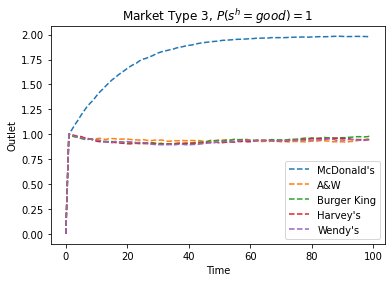

In [ ]:
import matplotlib.pyplot as plt
xx_range = np.arange(Tnew-1,dtype = int) +1
year =  np.arange(Tnew,dtype = int)
plt.plot(year,np.mean(ostate1,axis=1),'--',label='McDonald\'s')
plt.plot(year,np.mean(ostate2,axis=1),'--',label='A&W')
plt.plot(year,np.mean(ostate3,axis=1),'--',label='Burger King')
plt.plot(year,np.mean(ostate4,axis=1),'--',label='Harvey\'s')
plt.plot(year,np.mean(ostate5,axis=1),'--',label='Wendy\'s')
plt.ylabel('Outlet')
plt.xlabel('Time')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## market share

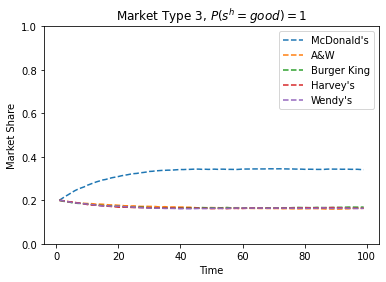

In [ ]:
import matplotlib.pyplot as plt
os1 = np.mean(ostate1,axis=1)
os2 = np.mean(ostate2,axis=1)
os3 = np.mean(ostate3,axis=1)
os4 = np.mean(ostate4,axis=1)
os5 = np.mean(ostate5,axis=1)
osSum = os1 +os2 +os3+os4+os5

# year = np.arange(Tnew,dtype = int) + 1970
plt.plot(year[xx_range],os1[xx_range]/osSum[xx_range],'--',label='McDonald\'s')
plt.plot(year[xx_range],os2[xx_range]/osSum[xx_range],'--',label='A&W')
plt.plot(year[xx_range],os3[xx_range]/osSum[xx_range],'--',label='Burger King')
plt.plot(year[xx_range],os4[xx_range]/osSum[xx_range],'--',label='Harvey\'s')
plt.plot(year[xx_range],os5[xx_range]/osSum[xx_range],'--',label='Wendy\'s')
plt.ylabel('Market Share')
plt.xlabel('Time')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylim(0,1)
plt.legend()
plt.show()

## Profit

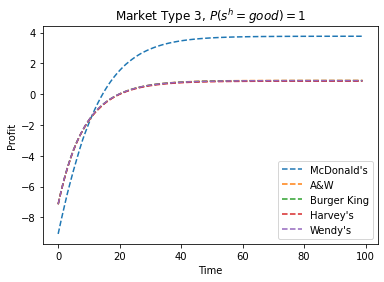

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Profit')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## Revenue

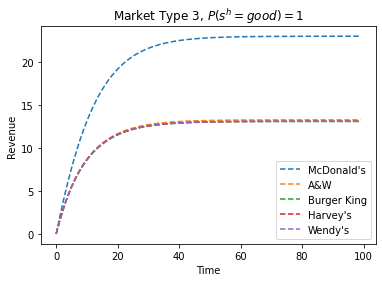

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([0*thetaS[2],0*thetaS[3],thetaS[4],thetaS[5],thetaS[6],0*thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([0*thetaS[10],0*thetaS[11],thetaS[12],thetaS[13],thetaS[14],0*thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Revenue')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

# Comparison (P(good)=0.5)

##Initial

In [12]:
prob_good = 0.5
theta23_real = np.array([1-prob_good,1-prob_good])
trans_real = RealDynamic(theta23_real)

In [13]:
from tqdm import tqdm
Nsub = 50
Tnew = 100
dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
dim_so = 4
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

def DataGeneration(theta1 = thetaS,theta23=theta23,Pi_new = Pi_new,T=Tnew,N=int(Nsub*NX),Nsub = Nsub,num=NX):
  # sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(theta23)
  # sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
  # iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
  # _, Pi_new,_ = ValueIteration(theta1,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  _,obser = Dynamic(theta23)
  #_,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)
  pi_disct = trans_real.copy()
  for i in range(200):
    pi_disct = pi_disct.dot(trans_real.copy())
  pi_disct = pi_disct[0]
  hstate = np.zeros([T,N],dtype= int)    #hidden state (s^h)
  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  s1state = np.zeros([T,N],dtype = int)   #population state z
  s2state = np.zeros([T,N],dtype = int)   #income state z
  s3state = np.zeros([T,N],dtype = int)   #property value state z

  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  sigma = np.zeros([T-1,N])

  belief[0,:] = np.kron(np.ones(Nsub),np.linspace(0,1,num))#np.random.uniform(size=N)
  hstate[0,:] = np.random.choice(np.arange(dim_hstate,dtype=int),size=N,p=pi_disct)#np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  zstate_mat  = np.random.random(size=N)
  zstate[0,:] = np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
                # np.int_(np.kron(z_data[0],
                #                 np.ones(Nsub*num,dtype = int)))#
  s1state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_pop[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  s2state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_val[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  s3state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_inc[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  ostate1[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_aw[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_bk[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_hvy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_wdy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  action1[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_aw[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_bk[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_hvy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_wdy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans_real[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income
    
    s1state_mat = np.random.random(size=N)
    ps11 = fz1_4x4[s1state[t],0]
    ps12 = fz1_4x4[s1state[t],1]
    ps13 = fz1_4x4[s1state[t],2]
    s1state[t+1,:] = np.int_(ps11<=s1state_mat) + np.int_(ps11 + ps12 <= s1state_mat) + np.int_(ps11 + ps12 + ps13 <= s1state_mat)
    s2state_mat = np.random.random(size=N)
    ps21 = fz2_4x4[s2state[t],0]
    ps22 = fz2_4x4[s2state[t],1]
    ps23 = fz2_4x4[s2state[t],2]
    s2state[t+1,:] = np.int_(ps21<=s2state_mat) + np.int_(ps21 + ps22 <= s2state_mat) + np.int_(ps21 + ps22 + ps23 <= s2state_mat)
    s3state_mat = np.random.random(size=N)
    ps31 = fz3_4x4[s3state[t],0]
    ps32 = fz3_4x4[s3state[t],1]
    ps33 = fz3_4x4[s3state[t],2]
    s3state[t+1,:] = np.int_(ps31<=s3state_mat) + np.int_(ps31 + ps32 <= s3state_mat) + np.int_(ps31 + ps32 + ps33 <= s3state_mat)

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta23,z_old=zstate[t+1],x_old =belief[t],T=1,num_discrete = num)
    
    # iterpolate belief
    belief_f = np.floor(belief[t+1,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t+1,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t+1,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4**4 +osj_mcd*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os2 = np.int_(ostate2[t+1,:]*4**4 + osj_aw*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os3 = np.int_(ostate3[t+1,:]*4**4 +osj_bk*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os4 = np.int_(ostate4[t+1,:]*4**4 + osj_hvy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os5 = np.int_(ostate5[t+1,:]*4**4 +osj_wdy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[0,belief_fint,os1] + (1-iterpolate)*pi1[0,belief_cint,os1]
    p12 = iterpolate*pi1[1,belief_fint,os1] + (1-iterpolate)*pi1[1,belief_cint,os1]
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint,os2] + (1-iterpolate)*pi2[0,belief_cint,os2]
    p22 = iterpolate*pi2[1,belief_fint,os2] + (1-iterpolate)*pi2[1,belief_cint,os2]
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)

    action_mat3 = np.random.random(size=N)
    p31 = iterpolate*pi2[0,belief_fint,os3] + (1-iterpolate)*pi2[0,belief_cint,os3]
    p32 = iterpolate*pi2[1,belief_fint,os3] + (1-iterpolate)*pi2[1,belief_cint,os3]
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = iterpolate*pi2[0,belief_fint,os4] + (1-iterpolate)*pi2[0,belief_cint,os4]
    p42 = iterpolate*pi2[1,belief_fint,os4] + (1-iterpolate)*pi2[1,belief_cint,os4]
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = iterpolate*pi2[0,belief_fint,os5] + (1-iterpolate)*pi2[0,belief_cint,os5]
    p52 = iterpolate*pi2[1,belief_fint,os5] + (1-iterpolate)*pi2[1,belief_cint,os5]
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)

  return hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma


hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma= DataGeneration()

100%|██████████| 99/99 [00:00<00:00, 383.11it/s]


##Outlet

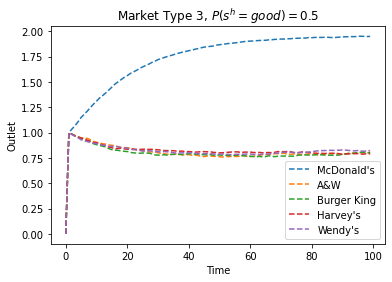

In [14]:
import matplotlib.pyplot as plt
xx_range = np.arange(Tnew-1,dtype = int) +1
year =  np.arange(Tnew,dtype = int)
plt.plot(year,np.mean(ostate1,axis=1),'--',label='McDonald\'s')
plt.plot(year,np.mean(ostate2,axis=1),'--',label='A&W')
plt.plot(year,np.mean(ostate3,axis=1),'--',label='Burger King')
plt.plot(year,np.mean(ostate4,axis=1),'--',label='Harvey\'s')
plt.plot(year,np.mean(ostate5,axis=1),'--',label='Wendy\'s')
plt.ylabel('Outlet')
plt.xlabel('Time')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## market share

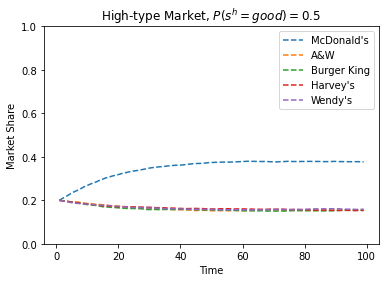

In [15]:
import matplotlib.pyplot as plt
os1 = np.mean(ostate1,axis=1)
os2 = np.mean(ostate2,axis=1)
os3 = np.mean(ostate3,axis=1)
os4 = np.mean(ostate4,axis=1)
os5 = np.mean(ostate5,axis=1)
osSum = os1 +os2 +os3+os4+os5

# year = np.arange(Tnew,dtype = int) + 1970
plt.plot(year[xx_range],os1[xx_range]/osSum[xx_range],'--',label='McDonald\'s')
plt.plot(year[xx_range],os2[xx_range]/osSum[xx_range],'--',label='A&W')
plt.plot(year[xx_range],os3[xx_range]/osSum[xx_range],'--',label='Burger King')
plt.plot(year[xx_range],os4[xx_range]/osSum[xx_range],'--',label='Harvey\'s')
plt.plot(year[xx_range],os5[xx_range]/osSum[xx_range],'--',label='Wendy\'s')
plt.ylabel('Market Share')
plt.xlabel('Time')
plt.title('High-type Market'+ r', $P(s^h=good)=$'+str(prob_good))
plt.ylim(0,1)
plt.legend()
plt.show()

## Profit

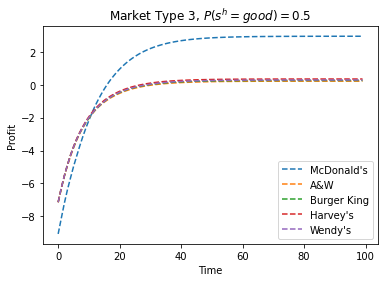

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Profit')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## Revenue

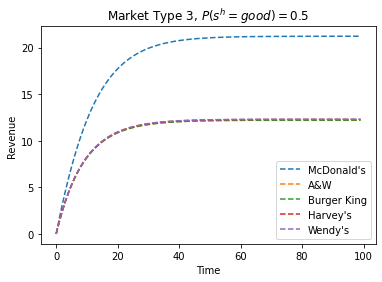

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([0*thetaS[2],0*thetaS[3],thetaS[4],thetaS[5],thetaS[6],0*thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([0*thetaS[10],0*thetaS[11],thetaS[12],thetaS[13],thetaS[14],0*thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Revenue')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

# Comparison (P(good)=0)

##Initial

In [ ]:
prob_good = 0
theta23_real = np.array([1-prob_good,1-prob_good])
trans_real = RealDynamic(theta23_real)

In [ ]:
from tqdm import tqdm
Nsub = 50
Tnew = 100
dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
dim_so = 4
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

def DataGeneration(theta1 = thetaS,theta23=theta23,Pi_new = Pi_new,T=Tnew,N=int(Nsub*NX),Nsub = Nsub,num=NX):
  # sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(theta23)
  # sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
  # iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
  # _, Pi_new,_ = ValueIteration(theta1,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  _,obser = Dynamic(theta23)
  #_,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)
  pi_disct = trans_real.copy()
  for i in range(200):
    pi_disct = pi_disct.dot(trans_real.copy())
  pi_disct = pi_disct[0]
  hstate = np.zeros([T,N],dtype= int)    #hidden state (s^h)
  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  s1state = np.zeros([T,N],dtype = int)   #population state z
  s2state = np.zeros([T,N],dtype = int)   #income state z
  s3state = np.zeros([T,N],dtype = int)   #property value state z

  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  sigma = np.zeros([T-1,N])

  belief[0,:] = np.kron(np.ones(Nsub),np.linspace(0,1,num))#np.random.uniform(size=N)
  hstate[0,:] = np.random.choice(np.arange(dim_hstate,dtype=int),size=N,p=pi_disct)#np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  zstate_mat  = np.random.random(size=N)
  zstate[0,:] = np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
                # np.int_(np.kron(z_data[0],
                #                 np.ones(Nsub*num,dtype = int)))#
  s1state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_pop[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  s2state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_val[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  s3state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_inc[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  ostate1[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_aw[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_bk[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_hvy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_wdy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  action1[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_aw[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_bk[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_hvy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_wdy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans_real[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income
    
    s1state_mat = np.random.random(size=N)
    ps11 = fz1_4x4[s1state[t],0]
    ps12 = fz1_4x4[s1state[t],1]
    ps13 = fz1_4x4[s1state[t],2]
    s1state[t+1,:] = np.int_(ps11<=s1state_mat) + np.int_(ps11 + ps12 <= s1state_mat) + np.int_(ps11 + ps12 + ps13 <= s1state_mat)
    s2state_mat = np.random.random(size=N)
    ps21 = fz2_4x4[s2state[t],0]
    ps22 = fz2_4x4[s2state[t],1]
    ps23 = fz2_4x4[s2state[t],2]
    s2state[t+1,:] = np.int_(ps21<=s2state_mat) + np.int_(ps21 + ps22 <= s2state_mat) + np.int_(ps21 + ps22 + ps23 <= s2state_mat)
    s3state_mat = np.random.random(size=N)
    ps31 = fz3_4x4[s3state[t],0]
    ps32 = fz3_4x4[s3state[t],1]
    ps33 = fz3_4x4[s3state[t],2]
    s3state[t+1,:] = np.int_(ps31<=s3state_mat) + np.int_(ps31 + ps32 <= s3state_mat) + np.int_(ps31 + ps32 + ps33 <= s3state_mat)

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta23,z_old=zstate[t+1],x_old =belief[t],T=1,num_discrete = num)
    
    # iterpolate belief
    belief_f = np.floor(belief[t+1,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t+1,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t+1,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4**4 +osj_mcd*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os2 = np.int_(ostate2[t+1,:]*4**4 + osj_aw*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os3 = np.int_(ostate3[t+1,:]*4**4 +osj_bk*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os4 = np.int_(ostate4[t+1,:]*4**4 + osj_hvy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os5 = np.int_(ostate5[t+1,:]*4**4 +osj_wdy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[0,belief_fint,os1] + (1-iterpolate)*pi1[0,belief_cint,os1]
    p12 = iterpolate*pi1[1,belief_fint,os1] + (1-iterpolate)*pi1[1,belief_cint,os1]
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint,os2] + (1-iterpolate)*pi2[0,belief_cint,os2]
    p22 = iterpolate*pi2[1,belief_fint,os2] + (1-iterpolate)*pi2[1,belief_cint,os2]
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)

    action_mat3 = np.random.random(size=N)
    p31 = iterpolate*pi2[0,belief_fint,os3] + (1-iterpolate)*pi2[0,belief_cint,os3]
    p32 = iterpolate*pi2[1,belief_fint,os3] + (1-iterpolate)*pi2[1,belief_cint,os3]
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = iterpolate*pi2[0,belief_fint,os4] + (1-iterpolate)*pi2[0,belief_cint,os4]
    p42 = iterpolate*pi2[1,belief_fint,os4] + (1-iterpolate)*pi2[1,belief_cint,os4]
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = iterpolate*pi2[0,belief_fint,os5] + (1-iterpolate)*pi2[0,belief_cint,os5]
    p52 = iterpolate*pi2[1,belief_fint,os5] + (1-iterpolate)*pi2[1,belief_cint,os5]
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)

  return hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma


hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma= DataGeneration()

100%|██████████| 99/99 [00:00<00:00, 377.68it/s]


##Outlet

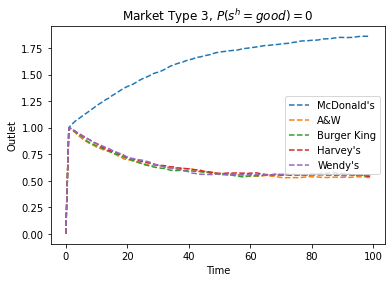

In [ ]:
import matplotlib.pyplot as plt
xx_range = np.arange(Tnew-1,dtype = int) +1
year =  np.arange(Tnew,dtype = int)
plt.plot(year,np.mean(ostate1,axis=1),'--',label='McDonald\'s')
plt.plot(year,np.mean(ostate2,axis=1),'--',label='A&W')
plt.plot(year,np.mean(ostate3,axis=1),'--',label='Burger King')
plt.plot(year,np.mean(ostate4,axis=1),'--',label='Harvey\'s')
plt.plot(year,np.mean(ostate5,axis=1),'--',label='Wendy\'s')
plt.ylabel('Outlet')
plt.xlabel('Time')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## market share

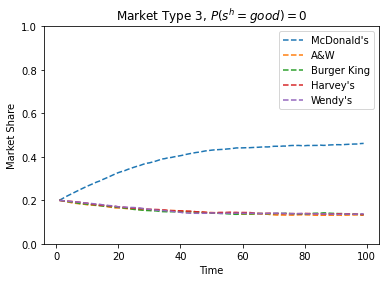

In [ ]:
import matplotlib.pyplot as plt
os1 = np.mean(ostate1,axis=1)
os2 = np.mean(ostate2,axis=1)
os3 = np.mean(ostate3,axis=1)
os4 = np.mean(ostate4,axis=1)
os5 = np.mean(ostate5,axis=1)
osSum = os1 +os2 +os3+os4+os5

# year = np.arange(Tnew,dtype = int) + 1970
plt.plot(year[xx_range],os1[xx_range]/osSum[xx_range],'--',label='McDonald\'s')
plt.plot(year[xx_range],os2[xx_range]/osSum[xx_range],'--',label='A&W')
plt.plot(year[xx_range],os3[xx_range]/osSum[xx_range],'--',label='Burger King')
plt.plot(year[xx_range],os4[xx_range]/osSum[xx_range],'--',label='Harvey\'s')
plt.plot(year[xx_range],os5[xx_range]/osSum[xx_range],'--',label='Wendy\'s')
plt.ylabel('Market Share')
plt.xlabel('Time')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylim(0,1)
plt.legend()
plt.show()

## Profit

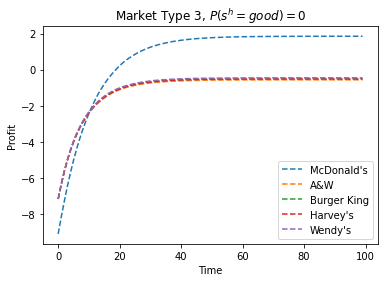

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Profit')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## Revenue

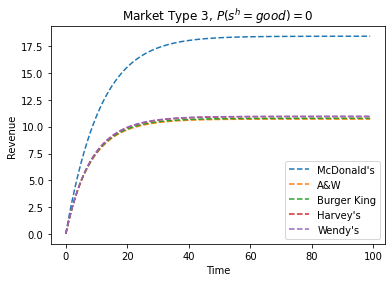

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([0*thetaS[2],0*thetaS[3],thetaS[4],thetaS[5],thetaS[6],0*thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([0*thetaS[10],0*thetaS[11],thetaS[12],thetaS[13],thetaS[14],0*thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Revenue')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

# Comparison (P(good)=0.95)

##Initial

In [16]:
prob_good = 0.95
theta23_real = np.array([1-prob_good,1-prob_good])
trans_real = RealDynamic(theta23_real)

In [17]:
from tqdm import tqdm
Nsub = 50
Tnew = 100
dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
dim_so = 4
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

def DataGeneration(theta1 = thetaS,theta23=theta23,Pi_new = Pi_new,T=Tnew,N=int(Nsub*NX),Nsub = Nsub,num=NX):
  # sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(theta23)
  # sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
  # iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
  # _, Pi_new,_ = ValueIteration(theta1,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  _,obser = Dynamic(theta23)
  #_,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)
  pi_disct = trans_real.copy()
  for i in range(200):
    pi_disct = pi_disct.dot(trans_real.copy())
  pi_disct = pi_disct[0]
  hstate = np.zeros([T,N],dtype= int)    #hidden state (s^h)
  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  s1state = np.zeros([T,N],dtype = int)   #population state z
  s2state = np.zeros([T,N],dtype = int)   #income state z
  s3state = np.zeros([T,N],dtype = int)   #property value state z

  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  sigma = np.zeros([T-1,N])

  belief[0,:] = np.kron(np.ones(Nsub),np.linspace(0,1,num))#np.random.uniform(size=N)
  hstate[0,:] = np.random.choice(np.arange(dim_hstate,dtype=int),size=N,p=pi_disct)#np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  zstate_mat  = np.random.random(size=N)
  zstate[0,:] = np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
                # np.int_(np.kron(z_data[0],
                #                 np.ones(Nsub*num,dtype = int)))#
  s1state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_pop[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  s2state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_val[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  s3state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_inc[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  ostate1[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_aw[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_bk[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_hvy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_wdy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  action1[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_aw[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_bk[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_hvy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_wdy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans_real[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income
    
    s1state_mat = np.random.random(size=N)
    ps11 = fz1_4x4[s1state[t],0]
    ps12 = fz1_4x4[s1state[t],1]
    ps13 = fz1_4x4[s1state[t],2]
    s1state[t+1,:] = np.int_(ps11<=s1state_mat) + np.int_(ps11 + ps12 <= s1state_mat) + np.int_(ps11 + ps12 + ps13 <= s1state_mat)
    s2state_mat = np.random.random(size=N)
    ps21 = fz2_4x4[s2state[t],0]
    ps22 = fz2_4x4[s2state[t],1]
    ps23 = fz2_4x4[s2state[t],2]
    s2state[t+1,:] = np.int_(ps21<=s2state_mat) + np.int_(ps21 + ps22 <= s2state_mat) + np.int_(ps21 + ps22 + ps23 <= s2state_mat)
    s3state_mat = np.random.random(size=N)
    ps31 = fz3_4x4[s3state[t],0]
    ps32 = fz3_4x4[s3state[t],1]
    ps33 = fz3_4x4[s3state[t],2]
    s3state[t+1,:] = np.int_(ps31<=s3state_mat) + np.int_(ps31 + ps32 <= s3state_mat) + np.int_(ps31 + ps32 + ps33 <= s3state_mat)

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta23,z_old=zstate[t+1],x_old =belief[t],T=1,num_discrete = num)
    
    # iterpolate belief
    belief_f = np.floor(belief[t+1,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t+1,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t+1,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4**4 +osj_mcd*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os2 = np.int_(ostate2[t+1,:]*4**4 + osj_aw*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os3 = np.int_(ostate3[t+1,:]*4**4 +osj_bk*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os4 = np.int_(ostate4[t+1,:]*4**4 + osj_hvy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os5 = np.int_(ostate5[t+1,:]*4**4 +osj_wdy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[0,belief_fint,os1] + (1-iterpolate)*pi1[0,belief_cint,os1]
    p12 = iterpolate*pi1[1,belief_fint,os1] + (1-iterpolate)*pi1[1,belief_cint,os1]
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint,os2] + (1-iterpolate)*pi2[0,belief_cint,os2]
    p22 = iterpolate*pi2[1,belief_fint,os2] + (1-iterpolate)*pi2[1,belief_cint,os2]
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)

    action_mat3 = np.random.random(size=N)
    p31 = iterpolate*pi2[0,belief_fint,os3] + (1-iterpolate)*pi2[0,belief_cint,os3]
    p32 = iterpolate*pi2[1,belief_fint,os3] + (1-iterpolate)*pi2[1,belief_cint,os3]
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = iterpolate*pi2[0,belief_fint,os4] + (1-iterpolate)*pi2[0,belief_cint,os4]
    p42 = iterpolate*pi2[1,belief_fint,os4] + (1-iterpolate)*pi2[1,belief_cint,os4]
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = iterpolate*pi2[0,belief_fint,os5] + (1-iterpolate)*pi2[0,belief_cint,os5]
    p52 = iterpolate*pi2[1,belief_fint,os5] + (1-iterpolate)*pi2[1,belief_cint,os5]
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)

  return hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma


hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma= DataGeneration()

100%|██████████| 99/99 [00:00<00:00, 415.96it/s]


##Outlet

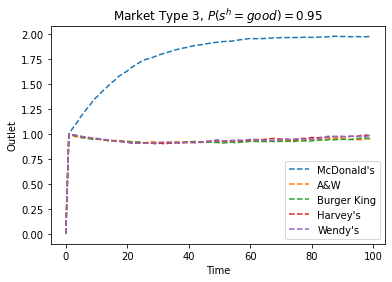

In [18]:
import matplotlib.pyplot as plt
xx_range = np.arange(Tnew-1,dtype = int) +1
year =  np.arange(Tnew,dtype = int)
plt.plot(year,np.mean(ostate1,axis=1),'--',label='McDonald\'s')
plt.plot(year,np.mean(ostate2,axis=1),'--',label='A&W')
plt.plot(year,np.mean(ostate3,axis=1),'--',label='Burger King')
plt.plot(year,np.mean(ostate4,axis=1),'--',label='Harvey\'s')
plt.plot(year,np.mean(ostate5,axis=1),'--',label='Wendy\'s')
plt.ylabel('Outlet')
plt.xlabel('Time')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## market share

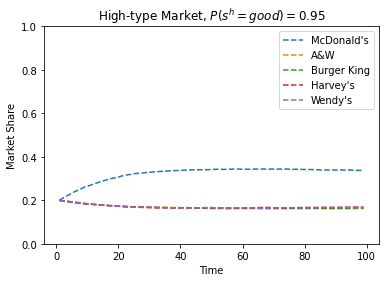

In [19]:
import matplotlib.pyplot as plt
os1 = np.mean(ostate1,axis=1)
os2 = np.mean(ostate2,axis=1)
os3 = np.mean(ostate3,axis=1)
os4 = np.mean(ostate4,axis=1)
os5 = np.mean(ostate5,axis=1)
osSum = os1 +os2 +os3+os4+os5

# year = np.arange(Tnew,dtype = int) + 1970
plt.plot(year[xx_range],os1[xx_range]/osSum[xx_range],'--',label='McDonald\'s')
plt.plot(year[xx_range],os2[xx_range]/osSum[xx_range],'--',label='A&W')
plt.plot(year[xx_range],os3[xx_range]/osSum[xx_range],'--',label='Burger King')
plt.plot(year[xx_range],os4[xx_range]/osSum[xx_range],'--',label='Harvey\'s')
plt.plot(year[xx_range],os5[xx_range]/osSum[xx_range],'--',label='Wendy\'s')
plt.ylabel('Market Share')
plt.xlabel('Time')
plt.title('High-type Market'+ r', $P(s^h=good)=$'+str(prob_good))
plt.ylim(0,1)
plt.legend()
plt.show()

## Profit

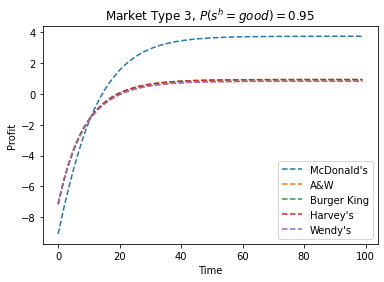

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Profit')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## Revenue

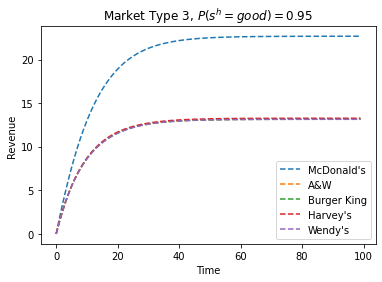

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([0*thetaS[2],0*thetaS[3],thetaS[4],thetaS[5],thetaS[6],0*thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([0*thetaS[10],0*thetaS[11],thetaS[12],thetaS[13],thetaS[14],0*thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Revenue')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

# Comparison (P(good)=0.3)

##Initial

In [20]:
prob_good = 0.3
theta23_real = np.array([1-prob_good,1-prob_good])
trans_real = RealDynamic(theta23_real)

In [21]:
from tqdm import tqdm
Nsub = 50
Tnew = 100
dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
dim_so = 4
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

def DataGeneration(theta1 = thetaS,theta23=theta23,Pi_new = Pi_new,T=Tnew,N=int(Nsub*NX),Nsub = Nsub,num=NX):
  # sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(theta23)
  # sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
  # iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
  # _, Pi_new,_ = ValueIteration(theta1,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  _,obser = Dynamic(theta23)
  #_,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)
  pi_disct = trans_real.copy()
  for i in range(200):
    pi_disct = pi_disct.dot(trans_real.copy())
  pi_disct = pi_disct[0]
  hstate = np.zeros([T,N],dtype= int)    #hidden state (s^h)
  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  s1state = np.zeros([T,N],dtype = int)   #population state z
  s2state = np.zeros([T,N],dtype = int)   #income state z
  s3state = np.zeros([T,N],dtype = int)   #property value state z

  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  sigma = np.zeros([T-1,N])

  belief[0,:] = np.kron(np.ones(Nsub),np.linspace(0,1,num))#np.random.uniform(size=N)
  hstate[0,:] = np.random.choice(np.arange(dim_hstate,dtype=int),size=N,p=pi_disct)#np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  zstate_mat  = np.random.random(size=N)
  zstate[0,:] = np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
                # np.int_(np.kron(z_data[0],
                #                 np.ones(Nsub*num,dtype = int)))#
  s1state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_pop[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  s2state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_val[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  s3state[0,:] = np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(disc_inc[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  ostate1[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_aw[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_bk[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_hvy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = 0*np.random.randint(0,dim_so,size=N)   
                 #np.int_(np.kron(Ni_wdy[tertile==mk].reshape([-1,35]).T[0],
                            #  np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  action1[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_aw[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_bk[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_hvy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.ones(N,dtype = int) +1
                 #np.int_(np.kron(ai_wdy[tertile==mk].reshape([-1,35]).T[0],
                                #  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans_real[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income
    
    s1state_mat = np.random.random(size=N)
    ps11 = fz1_4x4[s1state[t],0]
    ps12 = fz1_4x4[s1state[t],1]
    ps13 = fz1_4x4[s1state[t],2]
    s1state[t+1,:] = np.int_(ps11<=s1state_mat) + np.int_(ps11 + ps12 <= s1state_mat) + np.int_(ps11 + ps12 + ps13 <= s1state_mat)
    s2state_mat = np.random.random(size=N)
    ps21 = fz2_4x4[s2state[t],0]
    ps22 = fz2_4x4[s2state[t],1]
    ps23 = fz2_4x4[s2state[t],2]
    s2state[t+1,:] = np.int_(ps21<=s2state_mat) + np.int_(ps21 + ps22 <= s2state_mat) + np.int_(ps21 + ps22 + ps23 <= s2state_mat)
    s3state_mat = np.random.random(size=N)
    ps31 = fz3_4x4[s3state[t],0]
    ps32 = fz3_4x4[s3state[t],1]
    ps33 = fz3_4x4[s3state[t],2]
    s3state[t+1,:] = np.int_(ps31<=s3state_mat) + np.int_(ps31 + ps32 <= s3state_mat) + np.int_(ps31 + ps32 + ps33 <= s3state_mat)

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta23,z_old=zstate[t+1],x_old =belief[t],T=1,num_discrete = num)
    
    # iterpolate belief
    belief_f = np.floor(belief[t+1,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t+1,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t+1,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4**4 +osj_mcd*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os2 = np.int_(ostate2[t+1,:]*4**4 + osj_aw*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os3 = np.int_(ostate3[t+1,:]*4**4 +osj_bk*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os4 = np.int_(ostate4[t+1,:]*4**4 + osj_hvy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os5 = np.int_(ostate5[t+1,:]*4**4 +osj_wdy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[0,belief_fint,os1] + (1-iterpolate)*pi1[0,belief_cint,os1]
    p12 = iterpolate*pi1[1,belief_fint,os1] + (1-iterpolate)*pi1[1,belief_cint,os1]
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint,os2] + (1-iterpolate)*pi2[0,belief_cint,os2]
    p22 = iterpolate*pi2[1,belief_fint,os2] + (1-iterpolate)*pi2[1,belief_cint,os2]
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)

    action_mat3 = np.random.random(size=N)
    p31 = iterpolate*pi2[0,belief_fint,os3] + (1-iterpolate)*pi2[0,belief_cint,os3]
    p32 = iterpolate*pi2[1,belief_fint,os3] + (1-iterpolate)*pi2[1,belief_cint,os3]
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = iterpolate*pi2[0,belief_fint,os4] + (1-iterpolate)*pi2[0,belief_cint,os4]
    p42 = iterpolate*pi2[1,belief_fint,os4] + (1-iterpolate)*pi2[1,belief_cint,os4]
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = iterpolate*pi2[0,belief_fint,os5] + (1-iterpolate)*pi2[0,belief_cint,os5]
    p52 = iterpolate*pi2[1,belief_fint,os5] + (1-iterpolate)*pi2[1,belief_cint,os5]
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)

  return hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma


hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma= DataGeneration()

100%|██████████| 99/99 [00:00<00:00, 401.21it/s]


##Outlet

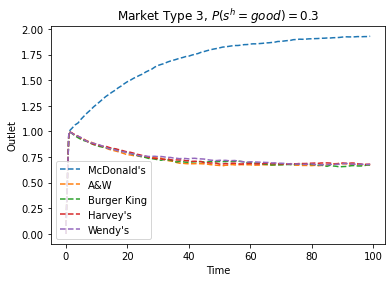

In [22]:
import matplotlib.pyplot as plt
xx_range = np.arange(Tnew-1,dtype = int) +1
year =  np.arange(Tnew,dtype = int)
plt.plot(year,np.mean(ostate1,axis=1),'--',label='McDonald\'s')
plt.plot(year,np.mean(ostate2,axis=1),'--',label='A&W')
plt.plot(year,np.mean(ostate3,axis=1),'--',label='Burger King')
plt.plot(year,np.mean(ostate4,axis=1),'--',label='Harvey\'s')
plt.plot(year,np.mean(ostate5,axis=1),'--',label='Wendy\'s')
plt.ylabel('Outlet')
plt.xlabel('Time')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## market share

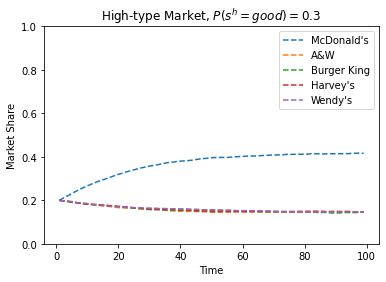

In [23]:
import matplotlib.pyplot as plt
os1 = np.mean(ostate1,axis=1)
os2 = np.mean(ostate2,axis=1)
os3 = np.mean(ostate3,axis=1)
os4 = np.mean(ostate4,axis=1)
os5 = np.mean(ostate5,axis=1)
osSum = os1 +os2 +os3+os4+os5

# year = np.arange(Tnew,dtype = int) + 1970
plt.plot(year[xx_range],os1[xx_range]/osSum[xx_range],'--',label='McDonald\'s')
plt.plot(year[xx_range],os2[xx_range]/osSum[xx_range],'--',label='A&W')
plt.plot(year[xx_range],os3[xx_range]/osSum[xx_range],'--',label='Burger King')
plt.plot(year[xx_range],os4[xx_range]/osSum[xx_range],'--',label='Harvey\'s')
plt.plot(year[xx_range],os5[xx_range]/osSum[xx_range],'--',label='Wendy\'s')
plt.ylabel('Market Share')
plt.xlabel('Time')
plt.title('High-type Market'+ r', $P(s^h=good)=$'+str(prob_good))
plt.ylim(0,1)
plt.legend()
plt.show()

## Profit

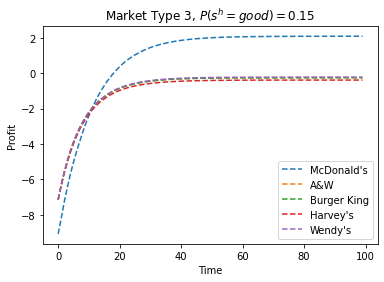

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Profit')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()

## Revenue

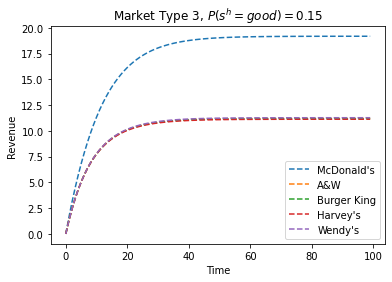

In [ ]:
beta = 0.9
beta_disct = np.array([[beta**i] for i in range(Tnew)])
def RewardPartial(thetaS):
  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([0*thetaS[2],0*thetaS[3],thetaS[4],thetaS[5],thetaS[6],0*thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([0*thetaS[10],0*thetaS[11],thetaS[12],thetaS[13],thetaS[14],0*thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  return R_new

num=NX
belief_f = np.floor(belief *(num-1))/(num-1)
belief_c = np.ceil(belief *(num-1))/(num-1)

iterpolate = np.zeros(belief_f.shape)
iter_n0 = np.where((belief_f-belief_c)!=0)
iterpolate[iter_n0] = (belief -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))
reward_partial = RewardPartial(thetaS) #I,J,NX,NS
# generate new action for both agents
osj_aw = ostate3+ ostate4  + ostate1 + ostate5
osj_bk = ostate2 + ostate4 + ostate1 + ostate5
osj_hvy = ostate2 + ostate3  + ostate1 + ostate5
osj_mcd = ostate2 + ostate3  + ostate4 + ostate5
osj_wdy = ostate2 + ostate3  + ostate4 + ostate1
osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

os1_ID = np.int_(ostate1*4**4 +osj_mcd*4**3 + s1state*4**2+ s2state*4+ s3state )
os2_ID = np.int_(ostate2*4**4 + osj_aw*4**3 + s1state*4**2+ s2state*4+ s3state )
os3_ID = np.int_(ostate3*4**4 +osj_bk*4**3 + s1state*4**2+ s2state*4+ s3state )
os4_ID = np.int_(ostate4*4**4 + osj_hvy*4**3 + s1state*4**2+ s2state*4+ s3state )
os5_ID = np.int_(ostate5*4**4 +osj_wdy*4**3 + s1state*4**2+ s2state*4+ s3state )

reward_mcd =beta_disct *(iterpolate*reward_partial[0,action1,belief_fint,os1_ID] + (1-iterpolate)*reward_partial[0,action1,belief_cint,os1_ID])
reward_aw = beta_disct *(iterpolate*reward_partial[1,action2,belief_fint,os2_ID] + (1-iterpolate)*reward_partial[1,action2,belief_cint,os2_ID])
reward_bk = beta_disct *(iterpolate*reward_partial[1,action3,belief_fint,os3_ID] + (1-iterpolate)*reward_partial[1,action3,belief_cint,os3_ID])
reward_hvy =beta_disct * (iterpolate*reward_partial[1,action4,belief_fint,os4_ID] + (1-iterpolate)*reward_partial[1,action4,belief_cint,os4_ID])
reward_wdy = beta_disct *(iterpolate*reward_partial[1,action5,belief_fint,os5_ID] + (1-iterpolate)*reward_partial[1,action5,belief_cint,os5_ID])

profit_mcd = np.zeros(Tnew)
profit_aw = np.zeros(Tnew)
profit_bk = np.zeros(Tnew)
profit_hvy = np.zeros(Tnew)
profit_wdy = np.zeros(Tnew)
profit_mcd[0] = np.mean(reward_mcd[0])
profit_aw[0] = np.mean(reward_aw[0])
profit_bk[0] = np.mean(reward_bk[0])
profit_hvy[0] = np.mean(reward_hvy[0])
profit_wdy[0] = np.mean(reward_wdy[0])
for i in range(1,Tnew):
  profit_mcd[i] = profit_mcd[i-1] + np.mean(reward_mcd[i])
  profit_aw[i] = profit_aw[i-1] + np.mean(reward_aw[i])
  profit_bk[i] = profit_bk[i-1] + np.mean(reward_bk[i])
  profit_hvy[i] = profit_hvy[i-1] + np.mean(reward_hvy[i])
  profit_wdy[i] = profit_wdy[i-1] + np.mean(reward_wdy[i])


plt.plot(year,profit_mcd,'--',label='McDonald\'s')
plt.plot(year,profit_aw,'--',label='A&W')
plt.plot(year,profit_bk,'--',label='Burger King')
plt.plot(year,profit_hvy,'--',label='Harvey\'s')
plt.plot(year,profit_wdy,'--',label='Wendy\'s')
plt.title('Market Type ' + str(mk) + r', $P(s^h=good)=$'+str(prob_good))
plt.ylabel('Revenue')
plt.xlabel('Time')
#plt.xlim(1965,2075)
plt.legend()
plt.show()